In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm
from sklearn import preprocessing, mixture
from hmmlearn import hmm
# from talib import RSI, BBANDS

In [3]:
NASDAQ = yf.Ticker("^DJI")

In [4]:
hist = NASDAQ.history(period='max')
hist['Daily Return'] = np.log(hist['Close'] / hist['Close'].shift(1))
hist = hist.loc['1999-01-01':]
hist.reset_index(inplace = True)
# hist = hist.set_index('Date')
# print(hist.head())
print(hist.tail())

           Date      Open      High       Low     Close     Volume  Dividends  \
5322 2020-02-28  25270.83  25494.24  24681.01  25409.36  915990000          0   
5323 2020-03-02  25590.51  26706.17  25391.96  26703.32  637200000          0   
5324 2020-03-03  26762.47  27084.59  25706.28  25917.41  647080000          0   
5325 2020-03-04  26383.68  27102.34  26286.31  27090.86  457590000          0   
5326 2020-03-05  26671.92  26671.92  25943.33  26121.28  477370000          0   

      Stock Splits  Daily Return  
5322             0     -0.013963  
5323             0      0.049670  
5324             0     -0.029873  
5325             0      0.044281  
5326             0     -0.036446  


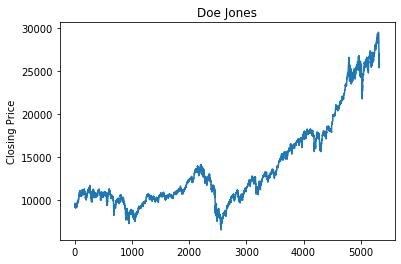

In [5]:
plt.title('Doe Jones')
# plt.xticks(ticks = hist['Date'])
plt.ylabel('Closing Price')
close = plt.plot(hist['Close'])

In [6]:
num_ID = 30000
features = []
for i in tqdm.tqdm(range(num_ID)):
    window = np.random.randint(20,40)
    start_ind = np.random.randint(0, len(hist) - window)
    watch = hist.iloc[start_ind : start_ind + window]
    end_date = max(watch['Date'])
    
    # Types of feature, each with chaining of length equals to window size
    volume_change = watch['Volume'].pct_change()
    exc_high = (watch['High'] - watch['Open']) / watch['Open']
    exc_low = (watch['Open'] - watch['Low']) / watch['Low']
    daily_change = (watch['Close'] - watch['Open']) / watch['Open']
    forcast = (watch['Open'].shift(-1) - watch['Open'])
    logret_w1 = np.log(watch['Close']/watch['Close'].shift(1))
    close = watch['Close']
    features.append(pd.DataFrame({'ID': [i] * window,
                                  'Window Size': [window] * window,
                                  'End Date': [end_date] * window,
                                  'Volume Change': volume_change,
                                  'Excessive High': exc_high,
                                  'Excessive Low': exc_low,
                                  'Daily Change': daily_change,
                                  'Daily Return': logret_w1,
                                  'Forcasted Change': forcast,
                                  'Close': close}))
featured = pd.concat(features)

100%|██████████| 30000/30000 [01:50<00:00, 271.50it/s]


In [7]:
featured = featured.dropna(how = 'any')
featured.head()

,ID,Window Size,End Date,Volume Change,Excessive High,Excessive Low,Daily Change,Daily Return,Forcasted Change,Close
2556,0,26,2009-04-07,0.043905,0.037571,0.000012,0.022202,0.022030,147.51,6875.84
2557,0,26,2009-04-07,0.096681,0.000000,0.050413,-0.040671,-0.041787,-278.85,6594.44
2558,0,26,2009-04-07,-0.165957,0.024262,0.019353,0.004819,0.004916,30.58,6626.94
2559,0,26,2009-04-07,-0.139191,0.012658,0.016707,-0.011876,-0.012129,-78.73,6547.05
2560,0,26,2009-04-07,0.748736,0.057962,0.000061,0.057962,0.056339,376.12,6926.49


In [8]:
compact = featured.groupby(['ID','End Date']).agg('mean').reset_index()
compact.set_index('End Date', inplace=True)
compact = compact.sort_index()
compact.index = pd.to_datetime(compact.index)
compact.tail()
# compact.groupby(compact.index).agg('mean').reset_index()

,ID,Window Size,Volume Change,Excessive High,Excessive Low,Daily Change,Daily Return,Forcasted Change,Close
End Date,,,,,,,,,
2020-03-04,844,35,0.040715,0.005981,0.008715,-0.002128,-0.003342,-76.306667,28539.766364
2020-03-04,4491,29,0.045530,0.006467,0.010161,-0.002893,-0.004366,-105.433704,28392.367778
2020-03-04,13771,20,0.054179,0.006679,0.012427,-0.004139,-0.006798,-166.938889,28222.074444
2020-03-04,28500,20,0.054179,0.006679,0.012427,-0.004139,-0.006798,-166.938889,28222.074444
2020-03-04,22478,31,0.041263,0.006181,0.009739,-0.002726,-0.004108,-99.308621,28446.216897


In [9]:
def norm(data):
    data = preprocessing.scale(data)
    return data

In [10]:
X = pd.DataFrame()
X['Close'] = norm(compact['Close'].values)
X['Daily Change'] = norm(compact['Daily Change'].values)
X['Volume Change'] = norm(compact['Volume Change'].values)
X['Excessive High'] = norm(compact['Excessive High'].values)
X['Excessive Low'] = norm(compact['Excessive Low'].values)
X['Forcasted Change'] = norm(compact['Forcasted Change'].values)
X['Daily Return'] = norm(compact['Daily Return'].values)
X.index = compact.index
X = X.reset_index()
features = ['Close', 'Daily Change', 'Volume Change', 'Excessive High', 'Excessive Low', 'Forcasted Change', 'Daily Return' ]

In [11]:
# X = X.groupby(X.index).agg('mean')
print(X.shape)
X.tail()

(30000, 8)


,End Date,Close,Daily Change,Volume Change,Excessive High,Excessive Low,Forcasted Change,Daily Return
29995,2020-03-04,2.779477,-1.323954,-0.076420,-0.125487,0.468665,-3.270334,-1.870069
29996,2020-03-04,2.751363,-1.746472,-0.001785,0.021627,0.800119,-4.463905,-2.410434
29997,2020-03-04,2.718882,-2.435371,0.132270,0.086023,1.319898,-6.984271,-3.693892
29998,2020-03-04,2.718882,-2.435371,0.132270,0.086023,1.319898,-6.984271,-3.693892
29999,2020-03-04,2.761634,-1.654446,-0.067924,-0.064789,0.703522,-4.212910,-2.273926


In [12]:
def get_best_hmm_model(data, max_states, max_iter = 10000):
    # score is the log likelihood
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in tqdm.tqdm(range(1, max_states + 1)):
        hmm_model = hmm.GaussianHMM(n_components = state, random_state = 100, covariance_type = 'diag', \
                                n_iter = max_iter).fit(data)
        if hmm_model.score(data) >= best_score:
            best_score = hmm_model.score(data)
            best_state = state
            
    best_model = hmm.GaussianHMM(n_components = best_state, random_state = 100, covariance_type = 'diag', \
                            n_iter = max_iter).fit(data)
    
    return best_model

In [13]:
# def BIC():
    
# def AIC():

In [74]:
def get_best_gmm_model(data, min_states, max_states):
    bic = []
    aic = []
#     aic = np.asarray([])
    window = 100
    num_obs = 400
    assert(window < num_ID)
    
    for i in tqdm.tqdm(range(min_states, max_states+1)):
        state_bic = []
        state_aic = []
        end_ind = len(data) - 1 - num_obs
        start_ind = end_ind - window
#         end_ind = start_ind + num_observations - 1
        counter = 0
        while counter < num_obs:
            curr_data = data[start_ind : end_ind + 1]
            gmm_model = mixture.GaussianMixture(n_components=i, covariance_type='diag').fit(curr_data)
            curr_bic = gmm_model.bic(curr_data)
            curr_aic = gmm_model.aic(curr_data)
            state_bic.append(curr_bic)
            state_aic.append(curr_aic)
            start_ind += 1
            end_ind += 1
            counter += 1
        
        bic.append(state_bic)
        aic.append(state_aic)
        
#         gmm_model = mixture.GaussianMixture(n_components=i, covariance_type='diag').fit(data)
#         curr_bic = gmm_model.bic(data)
#         curr_aic = gmm_model.aic(data)
# #         print(curr_bic)
#         bic = np.append(bic, curr_bic)
#         aic = np.append(aic, curr_aic)
# #         print(bic)
#         if curr_bic <= min(bic):
#             best_model = gmm_model
    return bic, aic, max_states


In [15]:
# model = hmm.GaussianHMM(n_components=5, covariance_type='diag', random_state=100, n_iter=100)
train_X = X[features].values
model = get_best_hmm_model(train_X, 6, 10000)
model

100%|██████████| 6/6 [00:29<00:00,  4.90s/it]


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10000, params='stmc',
            random_state=100, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=False)

In [16]:
hidden_states = model.predict(train_X)
hidden_states.shape

(30000,)

In [75]:
min_states = 2
max_states = 4
bic, aic, states= get_best_gmm_model(np.asarray(compact['Daily Return']).reshape(-1,1), min_states, max_states)
# bic, aic, states= get_best_gmm_model(train_X, min_states, max_states)


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


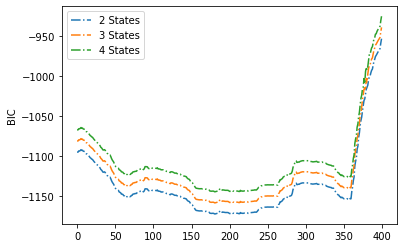

In [76]:
leg = []
i = min_states
for elem in bic:
    plt.plot(elem, linestyle = '-.')
    plt.ylabel("BIC")
    leg.append('{0} States'.format(i))
    plt.legend(leg)
    i += 1

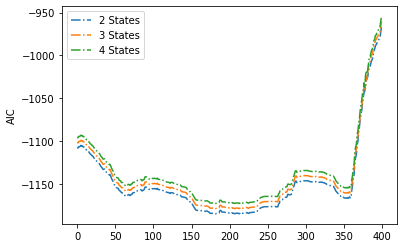

In [77]:
leg = []
i = min_states
for elem in aic:
    plt.plot(elem, linestyle = '-.')
    plt.ylabel("AIC")
    leg.append('{0} States'.format(i))
    plt.legend(leg)
    i += 1

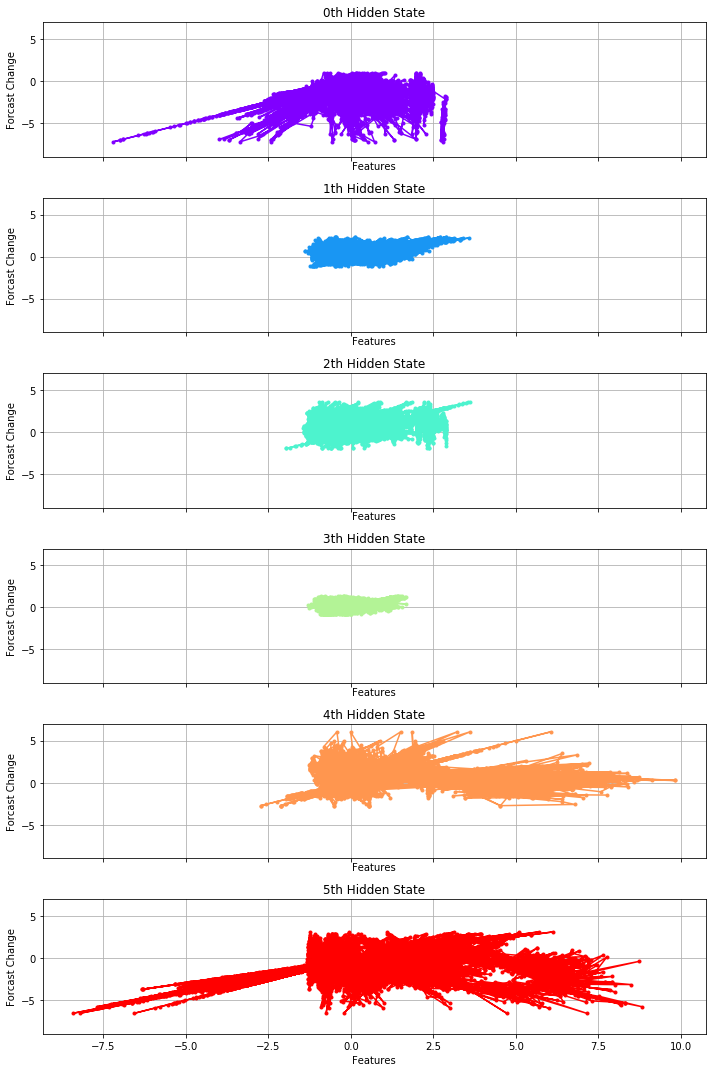

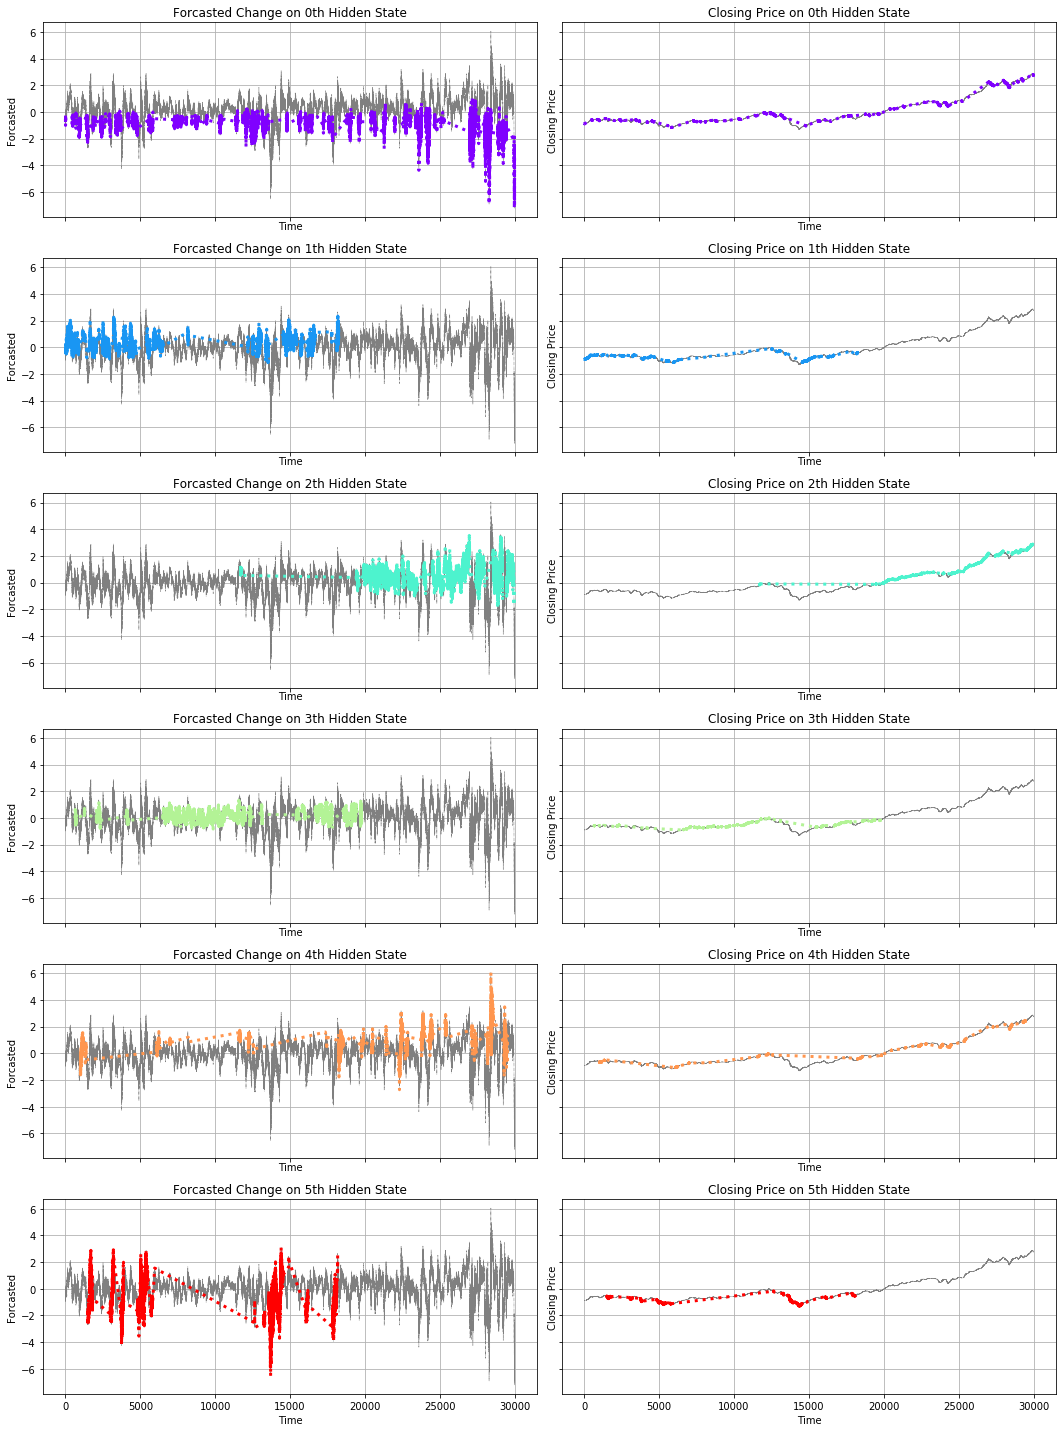

In [30]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(10,15))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = (hidden_states == i)
    ax.set_title("{0}th Hidden State".format(i))
    ax.plot(train_X[mask], X['Forcasted Change'][mask], '.-', c = color)
    ax.set_xlabel('Features')
    ax.set_ylabel('Forcast Change')
    ax.set_ylim(-9,7)
    ax.grid(True)
    plt.tight_layout()

fig, axs = plt.subplots(model.n_components, 2, sharex=True, sharey=True, figsize=(15,20))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = (hidden_states == i)
    ax[0].set_title("Forcasted Change on {0}th Hidden State".format(i))
    ax[0].plot(X.index, X['Forcasted Change'], c = 'grey', linewidth = 0.5, linestyle = '-.')
    ax[0].plot(X.index[mask], X['Forcasted Change'][mask], c = color, linewidth = 3, linestyle = ':')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Forcasted')
    ax[0].grid(True)

    ax[1].set_title("Closing Price on {0}th Hidden State".format(i))
    ax[1].plot(X.index, X['Close'], c = 'grey', linewidth = 0.5, linestyle = '--')
    ax[1].plot(X.index[mask], X['Close'][mask], c = color, linewidth = 3, linestyle = ':')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Closing Price')
    ax[1].grid(True)

plt.tight_layout()
